### Aluno Lucas Rodrigues Aragão (538390)

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

## Kmédias

In [70]:
class Kmedias:
    """
    cria um objeto da classe k medias
    """
    def __init__(self, k=5, distance_metric=None):
        self.k = k
        self.distance_metric = distance_metric  
        self.items_centroides = None
        self.centroides = None

    # Definições das funções de distância, que podem ser usadas de fora da classe
    @staticmethod
    def euclidian_distance(a, b, cov_matrix=None):
        return np.linalg.norm(a - b)

    @staticmethod
    def mahalanobis_distance(a, b, cov_matrix):
        delta = a - b
        return np.sqrt(np.dot(np.dot(delta.T, np.linalg.inv(cov_matrix)), delta))


    def initialize_centroids(self, train_data):
        """
        a funcao desse metodo eh inicializar os centroides usando a filosofia do kmedias ++
        """

        array_train_data = np.array(train_data)
        centroides = [array_train_data[np.random.choice(array_train_data.shape[0])]]

        for _ in range(1, self.k):
            distances = np.array([min([np.linalg.norm(point - centroide) for centroide in centroides]) for point in array_train_data])
            squared_distances = distances ** 2
            probabilities = squared_distances / np.sum(squared_distances)
            next_centroid_idx = np.random.choice(array_train_data.shape[0], p=probabilities)
            centroides.append(array_train_data[next_centroid_idx])

        self.centroides = np.array(centroides)
        return self.centroides

    def encontra_particao(self, data):
        """
        funcao para encontrar as particoes de cada instancia do conjunto de dados
        """
        centroides = self.centroides
        array_data = np.array(data)
        
        cov_matrix = np.cov(array_data.T) 
        
        items_centroides = []
        for item in array_data:
            distancias = [self.distance_metric(item, centroide, cov_matrix) for centroide in centroides]
            indice_mais_proximo = np.argmin(distancias)
            items_centroides.append(indice_mais_proximo)
        
        self.items_centroides = items_centroides
        return items_centroides

    def recalcula_centroides(self, data):
        """"
        funcao para recalcular os centroides apos as novas particoes serem encontradas
        """
        array_data = np.array(data)
        new_centroids = []

        for i in range(self.k):
            cluster_items = array_data[np.array(self.items_centroides) == i]
            if len(cluster_items) > 0:
                new_centroid = np.mean(cluster_items, axis=0)
            else:
                new_centroid = self.centroides[i]
            
            new_centroids.append(new_centroid)
        
        return np.array(new_centroids)

    def fit(self, train_data, threshold=10e-6): 
        self.centroides = self.initialize_centroids(train_data)
        centroides_antigos = self.centroides
        self.encontra_particao(train_data)
        diferenca_centroides = np.array([10e6] * self.k)

        while np.max(np.abs(diferenca_centroides)) > threshold:
            novos_centroides = self.recalcula_centroides(train_data)
            diferenca_centroides = novos_centroides - centroides_antigos
            centroides_antigos = novos_centroides
            self.encontra_particao(train_data)
        
        self.centroides = centroides_antigos
        return self.centroides


In [71]:
def find_best_k(data, k_values, n_runs=10, distance_metric=None):
    """
    funcao para achar o melhor como foi pedido na lista
    """
    best_k = None
    best_db_index = float('inf')
    best_labels = None
    best_centroids = None


    for k in k_values:
        best_db_for_k = float('inf')
        best_labels_for_k = None
        best_centroids_for_k = None


        for _ in range(n_runs):
            kmeans = Kmedias(k=k, distance_metric=distance_metric) 
            kmeans.fit(data)
            labels = kmeans.items_centroides
            centroids = kmeans.centroides
            
            # Calcula o índice Davies-Bouldin
            db_index = davies_bouldin_score(data, labels)
            
            if db_index < best_db_for_k:
                best_db_for_k = db_index
                best_labels_for_k = labels
                best_centroids_for_k = centroids

        if best_db_for_k < best_db_index:
            best_db_index = best_db_for_k
            best_k = k
            best_labels = best_labels_for_k
            best_centroids = best_centroids_for_k

    return best_k, best_labels, best_centroids

def plot_clusters(data, labels, centroids):
    
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', marker='o')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centróides')
    plt.title(f'Melhor agrupamento com K={len(centroids)} baseado no Índice Davies-Bouldin')
    plt.legend()
    plt.show()




## Questão 1

In [72]:
dados_1 = pd.read_csv('quake.csv')
dados_1 = dados_1.sample(frac= 1).reset_index(drop= True)
scaler = StandardScaler()
dados_normalizados = scaler.fit_transform(dados_1.select_dtypes(include=[np.number]))

k_values = range(4, 21)

### item a

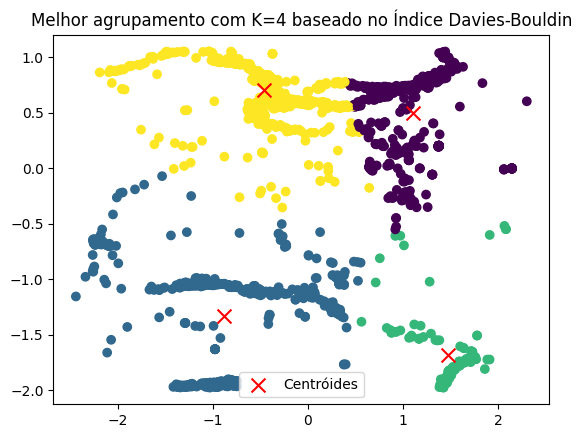

In [73]:
best_k, best_labels, best_centroids = find_best_k(dados_normalizados, k_values=k_values, n_runs=10, distance_metric=Kmedias.euclidian_distance)

plot_clusters(dados_normalizados, best_labels, best_centroids)

### item b

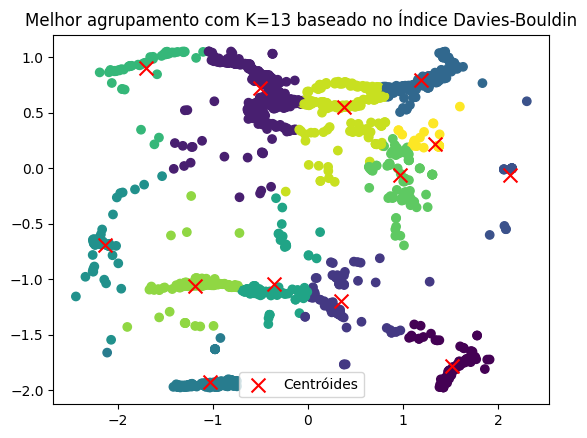

In [74]:
best_k, best_labels, best_centroids = find_best_k(dados_normalizados, k_values=k_values, n_runs=10, distance_metric=Kmedias.mahalanobis_distance)

plot_clusters(dados_normalizados, best_labels, best_centroids)


## PCA

In [75]:
class PCA():
    """
    cria um objeto da classe PCA
    """
    def __init__(self, n_componentes):
        self.n_componentes = n_componentes
        self.matriz_projecao = None
        self.variancia_explicada = None

    def fit_transform(self, data):
        """
        faz o fit do modelo aos dados e retorna eles projetados na dimensao escolhida
        """
        m = self.n_componentes
        data_array = np.array(data)
        
        ## calcular matriz de covariância
        cov_matrix = np.cov(data_array.T)
        
        ## encontra todos os autovalores e autovetores
        autovalores, autovetores = np.linalg.eigh(cov_matrix)
        
        ## pegar os M maiores autovalores e autovetores
        index = np.argsort(autovalores)[::-1]  # Ordenar autovalores em ordem decrescente
        autovalores = autovalores[index]  # Autovalores reordenados
        autovetores = autovetores[:, index]  # Autovetores reordenados
        
        ## selecionar os M maiores autovetores
        autovetores_selecionados = autovetores[:, :self.n_componentes]
        
        ## formar matriz de projeção
        self.matriz_projecao = autovetores_selecionados
        
        ## calcular variância explicada
        self.variancia_explicada = np.sum(autovalores[:self.n_componentes]) / np.sum(autovalores)

        # fazer a projeção dos dados usando a matriz de projeção
        return np.dot(data_array, self.matriz_projecao)


## Questão 2

In [76]:
dados_2 = pd.read_csv('penguins.csv')
dados_2.sample(frac=1).reset_index(drop =True)
scaler = StandardScaler()
dados_normalizados_2 = scaler.fit_transform(dados_2.select_dtypes(include=[np.number]))

In [77]:
pca = PCA(n_componentes=2)
data_projetado = pca.fit_transform(data= dados_normalizados_2)

### Item a

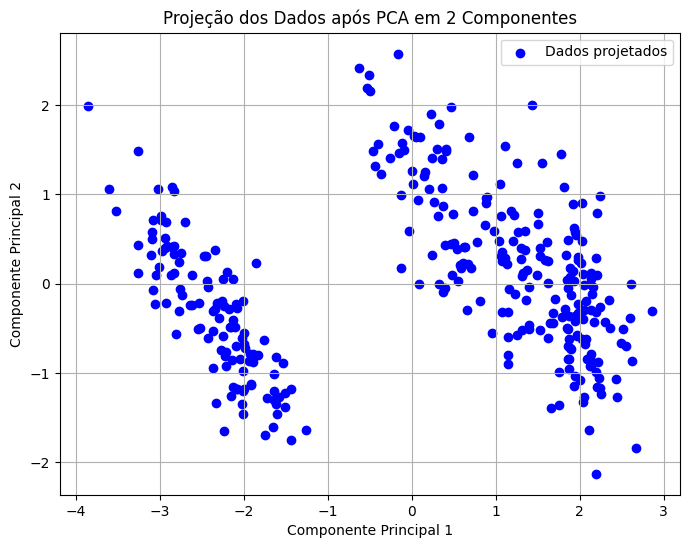

In [78]:

plt.figure(figsize=(8, 6))
plt.scatter(data_projetado[:, 0], data_projetado[:, 1], c='blue', label='Dados projetados')
plt.title('Projeção dos Dados após PCA em 2 Componentes')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.show()

### Item b

In [79]:
for i in range(1, 5):
    print('='*30)
    print(f'Usando a dimensão {i}')
    pca = PCA(n_componentes= i)
    res = pca.fit_transform(dados_normalizados_2)
    print(f'Variancia explicada: {pca.variancia_explicada}')

Usando a dimensão 1
Variancia explicada: 0.7272776521958192
Usando a dimensão 2
Variancia explicada: 0.884582524729975
Usando a dimensão 3
Variancia explicada: 0.9672105911533883
Usando a dimensão 4
Variancia explicada: 0.9887977883212082
